# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/

/content/drive/My Drive


# Import raw data

In [ ]:
import pandas as pd

df_raw = pd.read_csv("steam-200k.csv", usecols=[0,1,2,3],names=['userid','game','behavior','hoursplayed'])
df_raw.head()

,userid,game,behavior,hoursplayed
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


# Preprocessing

In [ ]:
print("Data Description:\n")
df_raw.describe()

Data Description:



,userid,hoursplayed
count,2.000000e+05,200000.000000
mean,1.036559e+08,17.874384
std,7.208074e+07,138.056952
min,5.250000e+03,0.100000
25%,4.738420e+07,1.000000
50%,8.691201e+07,1.000000
75%,1.542309e+08,1.300000
max,3.099031e+08,11754.000000


In [ ]:
df_raw['userid'] = df_raw.userid.astype(str) #Convert userid to string because it was considered as integer as seen from data description

In [ ]:
print("Null values: ", df_raw.isnull().values.any())

Null values:  False


In [ ]:
print("Top games played on average hours: \n")
df_raw.groupby(['game']).mean().sort_values(by="hoursplayed",ascending=False).head()

Top games played on average hours: 



,hoursplayed
game,
Eastside Hockey Manager,648.000000
FIFA Manager 09,206.000000
Perpetuum,200.987500
Football Manager 2012,194.501887
Football Manager 2014,194.017722


In [ ]:
print("Top games played for total hours: \n")
df_raw.groupby(['game']).sum().sort_values(by="hoursplayed",ascending=False).head()

Top games played for total hours: 



,hoursplayed
game,
Dota 2,986525.6
Counter-Strike Global Offensive,324183.6
Team Fortress 2,175996.3
Counter-Strike,135117.1
Sid Meier's Civilization V,100417.3


In [ ]:
n_users = len(df_raw['game'].unique())
print("Unique number of games: ", n_users)

Unique number of games:  5155


In [ ]:
n_games = len(df_raw['userid'].unique())
print("Unique number of users: ", n_games)

Unique number of users:  12393


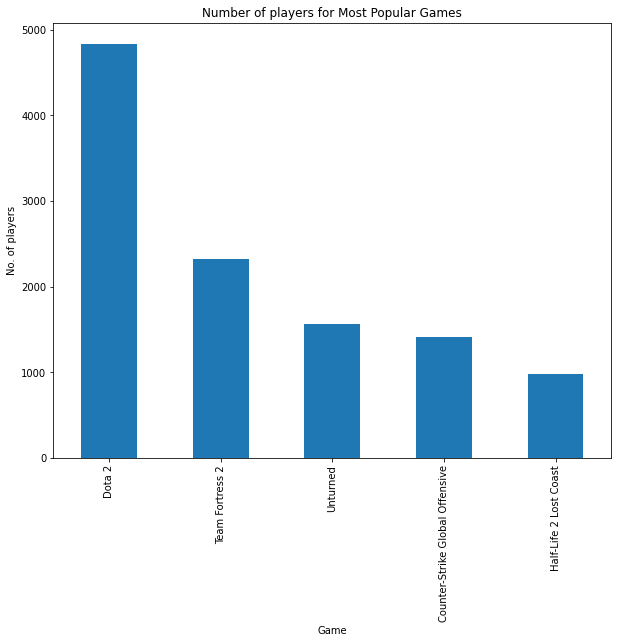

In [ ]:
import matplotlib.pyplot as plt

users_per_game = df_raw.groupby('game')['userid'].nunique().sort_values(ascending=False).head()
ax = users_per_game.plot(kind='bar', title='Number of players for Most Popular Games', ylabel='No. of players',
         xlabel='Game', figsize=(10, 8))

In [ ]:
df_clean = df_raw.copy()
df_clean['like'] = [1 if x > 40 else 0 for x in df_clean['hoursplayed']] #we choose 40 hours as a threshold to say if a user likes a game or not
print("Total likes and dislikes for a game:\n")
df_clean['like'].value_counts()

Total likes and dislikes for a game:



0    189067
1     10933
Name: like, dtype: int64

In [ ]:
likes_per_game=df_clean.groupby('game')['like'].apply(lambda x: (x==1).sum()).sort_values(ascending=False)
print("Number of likes per games:\n")
likes_per_game.head()

Number of likes per games:



game
Dota 2                             1417
Counter-Strike Global Offensive     776
Team Fortress 2                     480
The Elder Scrolls V Skyrim          362
Sid Meier's Civilization V          265
Name: like, dtype: int64

In [ ]:
print("Number of users per games:\n")
users_per_game.head()

Number of users per games:



game
Dota 2                             4841
Team Fortress 2                    2323
Unturned                           1563
Counter-Strike Global Offensive    1412
Half-Life 2 Lost Coast              981
Name: userid, dtype: int64

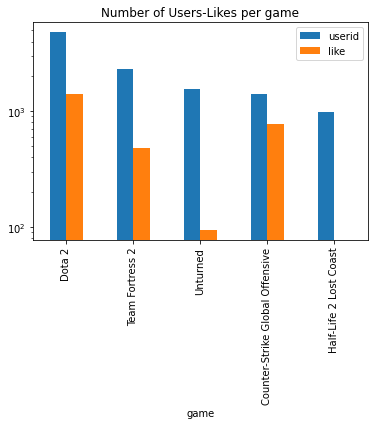

In [ ]:
users_and_likes_per_game = pd.merge(users_per_game, likes_per_game, on='game')
ax1 = users_and_likes_per_game.plot.bar(logy=True, title='Number of Users-Likes per game')

In [ ]:
x = df_clean.groupby(['userid', 'game'])['behavior'].size() #number of user-game pairs that have purchased and/or played the game
s = x[x == 1] #number of user-game pairs that have only purchased the game

boolean_index = df_clean.groupby(['userid','game'])['behavior'].transform('size') < 2 #boolean set to true if only purchased the game
df_clean.loc[boolean_index,'hoursplayed'] = 0 #set hours played to 0 if boolean true
df_clean.loc[df_clean['hoursplayed'] ==0] #select dataframe to 0 hoursplayed

df_clean.loc[df_clean.hoursplayed==0,'behavior'] = 'play' #set behavior as play for games played for 0 hours

df_clean.loc[df_clean['hoursplayed'] ==0] #select dataframe to 0 hoursplayed
df_clean = df_clean[df_clean.behavior != 'purchase'] #remove rows with behavior as purchase

In [ ]:
df_games = pd.DataFrame(df_clean.game.unique(), columns=['game'])
df_games['game_index'] = df_games.index
df_games

,game,game_index
0,The Elder Scrolls V Skyrim,0
1,Fallout 4,1
2,Spore,2
3,Fallout New Vegas,3
4,Left 4 Dead 2,4
...,...,...
5150,Warriors & Castles,5150
5151,Romance of the Three Kingdoms Maker,5151
5152,Space Colony,5152
5153,Life is Hard,5153


In [ ]:
df_clean = df_clean.merge(df_games, on='game')
df_clean.head()

,userid,game,behavior,hoursplayed,like,game_index
0,151603712,The Elder Scrolls V Skyrim,play,273.0,1,0
1,59945701,The Elder Scrolls V Skyrim,play,58.0,1,0
2,53875128,The Elder Scrolls V Skyrim,play,0.0,0,0
3,92107940,The Elder Scrolls V Skyrim,play,110.0,1,0
4,250006052,The Elder Scrolls V Skyrim,play,465.0,1,0


# Recommender System
Restricted Boltzmann Machine


In [ ]:
usergroup = df_clean.groupby('userid')
usergroup.head()

,userid,game,behavior,hoursplayed,like,game_index
0,151603712,The Elder Scrolls V Skyrim,play,273.0,1,0
1,59945701,The Elder Scrolls V Skyrim,play,58.0,1,0
2,53875128,The Elder Scrolls V Skyrim,play,0.0,0,0
3,92107940,The Elder Scrolls V Skyrim,play,110.0,1,0
4,250006052,The Elder Scrolls V Skyrim,play,465.0,1,0
...,...,...,...,...,...,...
128313,162653477,Fast & Furious Showdown,play,3.4,0,5077
128340,213854339,Eastside Hockey Manager,play,1295.0,1,5102
128341,213854339,Franchise Hockey Manager 2,play,11.2,0,5103
128345,178144284,Phantom Breaker Battle Grounds - Kurisu Makise...,play,0.0,0,5107


In [ ]:
noOfUsers = 1000

train_key_list = []
train_val_list = []
train_list = []

i = 0

for userID, cur in usergroup:
  train_key_list.append(userID)
  temp = [0]*len(df_games) # temp that stores every game's hours played
  
  for no, game in cur.iterrows():
    temp[game['game_index']] = game['hoursplayed']
    i+=1
  train_val_list.append(temp)
  train_list.append(temp)
  
  if noOfUsers == 0:
    break
  noOfUsers -= 1

train_dict = dict(zip(train_key_list, train_val_list))
train_keys = list(train_dict.keys())

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Setting the models Parameters
hiddenUnits = 50
visibleUnits = len(df_clean['game'].unique())
vb = tf.placeholder(tf.float32, [visibleUnits])  
hb = tf.placeholder(tf.float32, [hiddenUnits]) 
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits]) 

# Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) 

# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

# Learning rate
alpha = 1

# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

err_sum

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use `tf.cast` instead.


<tf.Tensor 'Mean_2:0' shape=() dtype=float32>

140.69798
140.70235
140.7104
140.71341
140.7125
140.70905
140.70557
140.70306
140.70009
140.69878
140.69658
140.69527
140.69453
140.69319
140.6921
140.69206
140.6907
140.69011
140.68962
140.68997
140.68849
140.68875
140.68832
140.6883
140.68752
140.68817
140.68692
140.68736
140.68713
140.68665


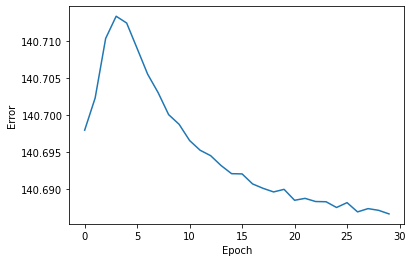

In [ ]:
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

cur_vb = np.zeros([visibleUnits], np.float32)

cur_hb = np.zeros([hiddenUnits], np.float32)

prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

prv_vb = np.zeros([visibleUnits], np.float32)

prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 30
batchsize = 150
errors = []
for i in range(epochs):
    for start, end in zip(range(0, len(train_list), batchsize), range(batchsize, len(train_list), batchsize)):
        batch = train_list[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: train_list, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [ ]:
inputUser = np.reshape(train_dict[train_keys[99]], (1, 5155)).tolist()
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

# List the 10 most recommended games for our mock user
inputuser_games = df_games
inputuser_games["recommendation_score"] = rec[0]
inputuser_games.sort_values(["recommendation_score"], ascending=False).head(10)

,game,game_index,recommendation_score
0,The Elder Scrolls V Skyrim,0,1.0
613,Day of Defeat,613,1.0
1424,Football Manager 2014,1424,1.0
1441,Zombie Panic Source,1441,1.0
567,Warframe,567,1.0
550,ARK Survival Evolved,550,1.0
549,Empire Total War,549,1.0
42,Sid Meier's Civilization V,42,1.0
544,Counter-Strike Source,544,1.0
543,Call of Duty Black Ops - Multiplayer,543,1.0


In [ ]:
userid = train_keys[99]

muser_df = df_clean.loc[(df_clean['userid'] == userid) & (df_clean['hoursplayed'] >0)] #all games this input user has played

In [ ]:
df_all = inputuser_games.merge(muser_df, how='left', indicator=True)
unplayed_games = df_all[df_all['_merge']=='left_only']

# Any Top 5 unplayed recommended games
final_rec = unplayed_games.loc[:,['game','recommendation_score']].sort_values(['recommendation_score'], ascending=False).head(5)
result = final_rec.filter(items=['game'])
result

,game
0,The Elder Scrolls V Skyrim
1043,Might & Magic Heroes VI
550,ARK Survival Evolved
567,Warframe
611,Counter-Strike
